# Group Number:

# Student 1: Ryan Meghoe

# Student 2: Nikita Jain

# Student 3: Andrei Rykov

# Downloading Data and Preliminaries

In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from zipfile import ZipFile
import requests
import io

In [2]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_array(zipfile, fn):
    return np.load(io.BytesIO(zipfile[fn]))

In [3]:
"""
This cell loads the training, validation or test data as numpy arrays,
with the positions, initial velocities and charge data of the particles.

The position arrays are shaped as
[simulation id, time point (corresponding to t = 0, 0.5, 1 or 1.5), x/y spatial dimension, particle id].

The initial velocity arrays are shaped as
[simulation id, 1 (corresponding to t=0), x/y spatial dimension, particle id].

The charge arrays are shaped as [simulation id, particle id, 1]

"""

data = load_zip('https://surfdrive.surf.nl/files/index.php/s/OIgda2ZRG8v0eqB/download')

features = ['positions', 'velocities', 'charges']
    
positions_train, velocities_train, charges_train = (load_array(data, f'data/train/{f}.npy') for f in features)
positions_valid, velocities_valid, charges_valid = (load_array(data, f'data/valid/{f}.npy') for f in features)
positions_test, velocities_test, charges_test = (load_array(data, f'data/test/{f}.npy') for f in features)

print('Shapes of the training data:\n')
print(f'positions: {positions_train.shape}')
print(f'velocities: {velocities_train.shape}')
print(f'charges: {charges_train.shape}')

Shapes of the training data:

positions: (10000, 4, 2, 5)
velocities: (10000, 1, 2, 5)
charges: (10000, 5, 1)


In [4]:
print('An example of retrieving data from the arrays:\n\n')

sim_idx = 42
t_idx = 2  # t_idx 0, 1, 2, 3 corresponds to t=0, 0.5, 1 and 1.5 respectively
spatial_idx = (0,1)  # corresponds to both x and y dimension
particle_idx = 3  # corresponds to particle with index 3

p = positions_train[sim_idx, t_idx, spatial_idx, particle_idx]
v = velocities_train[sim_idx, 0, spatial_idx, particle_idx]  # note: this array contains only the inital velocity -> hence the 0
c = charges_train[sim_idx, particle_idx, 0] 

print(
    f'In simulation {sim_idx} of the training set, particle {particle_idx} with charge {c} had coordinates {p}.\nThe initial velocity of this particle was {v}.'
)

An example of retrieving data from the arrays:


In simulation 42 of the training set, particle 3 with charge -1.0 had coordinates [ 2.05159559 -1.46130851].
The initial velocity of this particle was [ 0.28402364 -0.24784824].


In [5]:
print('Overview of no. datapoints:\n')

print(f'{len(positions_train)} train, {len(positions_valid)} validation, {len(positions_test)} test simulations')

Overview of no. datapoints:

10000 train, 2000 validation, 2000 test simulations


In [6]:
def plot_example(pos, vel):

    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    colors = ['red', 'blue', 'green', 'orange', 'brown']
    for i in range(pos.shape[-1]):
        plt.plot(pos[0, 0, i], pos[0, 1, i], 'd', color=colors[i])
        plt.plot(pos[-1, 0, i], pos[-1, 1, i], 'x', color=colors[i])
        plt.plot([pos[0, 0, i], pos[0, 0, i] + vel[0, 0, i]], [pos[0, 1, i], pos[0, 1, i] + vel[0, 1, i]], '--', color=colors[i])
    fig.set_size_inches(7, 7)
    plt.xlim(np.min(pos)-1, np.max(pos) +1)
    plt.ylim(np.min(pos)-1, np.max(pos) +1)
    plt.plot([], [], 'd', color='black', label='initial position')
    plt.plot([], [], 'x', color='black', label='final position')
    plt.plot([], [], '--', color='black', label='initial velocity \ndirection and magnitude')
    plt.legend()
    
    plt.show()
    return

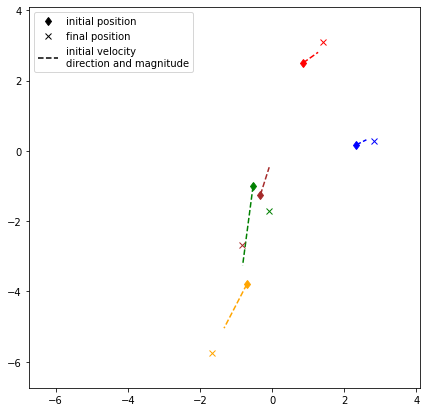

In [7]:
random_idx = np.random.randint(0, 10000)
plot_example(positions_train[random_idx], velocities_train[random_idx])

# Data Handling and Preprocessing

In [8]:
import torch

X_train = torch.cat((torch.tensor(positions_train[:,0,:,:]), torch.tensor(charges_train).squeeze(-1).unsqueeze(1)), dim=1)
X_train = torch.cat((X_train, torch.tensor(velocities_train).squeeze(1)), dim=1) # shape: (simulation id, parameters (x, y, c, v_x, v_y), particle id)
y_train = torch.tensor(positions_train[:,1:,:,:]) # shape: (simulation id, time (0.5, 1, 1.5), (x, y), particle id)

X_valid = torch.cat((torch.tensor(positions_valid[:,0,:,:]), torch.tensor(charges_valid).squeeze(-1).unsqueeze(1)), dim=1)
X_valid = torch.cat((X_valid, torch.tensor(velocities_valid).squeeze(1)), dim=1)
y_valid = torch.tensor(positions_valid[:,1:,:,:])

X_test = torch.cat((torch.tensor(positions_test[:,0,:,:]), torch.tensor(charges_test).squeeze(-1).unsqueeze(1)), dim=1)
X_test = torch.cat((X_test, torch.tensor(velocities_test).squeeze(1)), dim=1)
y_test = torch.tensor(positions_test[:,1:,:,:])

In [9]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)
test_dataset = TensorDataset(X_test, y_test)

In [23]:
batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model Implementation

In [24]:
import torch.nn as nn
import torch.nn.functional as F

class ParticleModel(torch.nn.Module):
    def __init__(self, set_size: int = 5, input_size: int = 5, 
                 fau1_out: int = 32, gamma1_out: int = 32, fau2_out: int = 32, gamma2_out: int = 2, device: torch.device = torch.device('cpu')):
        super(ParticleModel, self).__init__()
        # first iteration 
        # layer 1
        # input target (x_t, y_t, c_t, v_t) + neighbour (x_n, y_n, c_n, v_n) + edge (distance(t, n)) 
        # as the result input for first layer is x + x + 1 = 2x + 1 (8 + 1 in our case)
        self.fau_iteration1 = nn.Sequential(nn.Linear(input_size*2 + 1, fau1_out),
                                            nn.LeakyReLU())
        # embeddings are calculated

        # layer 2
        # input (x_target, y_target, c_target, v_target) + embedding from layer_1 + time
        self.gamma_iteration1 = nn.Sequential(nn.Linear(fau1_out+input_size+1, gamma1_out),
                                              nn.LeakyReLU())
        self.embedding_size = (set_size, gamma1_out)

        # second iteration 
        # layer 3
        # input target (embedding from layer 1) + neigbour (embedding from layer 1) + edge (distance(t, n))
        self.fau_iteration2 = nn.Sequential(nn.Linear(gamma1_out*2 + 1, fau2_out),
                                            nn.LeakyReLU())
        # embeddings are calculated

        # layer 4
        # input (x_target, y_target, c_target, v_target) + embedding from layer_3 + time
        self.gamma_iteration2 = nn.Sequential(nn.Linear(fau2_out + gamma1_out + 1, gamma2_out))
        self.output_size = (set_size, gamma2_out)
        self.device = device

    
    def forward_iteration1(self, particle_set, distances, target_time: float = 2.):
        embedding = torch.zeros((particle_set.shape[0], self.embedding_size[0], self.embedding_size[1])).to(self.device)
        
        for i in range(particle_set.shape[1]):
            # concatenate the neighborhood
            x = torch.cat([particle_set[:,i].reshape((particle_set.shape[0], 1, 5)).repeat((1, particle_set.shape[1] - 1, 1)),
                           particle_set[:, list(set(range(particle_set.shape[1])).difference({i}))],
                           distances[:, i, list(set(range(particle_set.shape[1])).difference({i}))].reshape((particle_set.shape[0],\
                                                                                                   particle_set.shape[1]-1,1))],
                          2)


            x = self.fau_iteration1(x)

            # aggregation function
            # mean as a placeholder for now
            x = x.mean(axis = 1)
            # concatenate 
            x = torch.cat([particle_set[:, i].view(particle_set.shape[0], 1, -1),
                           x.view(particle_set.shape[0], 1, -1),
                           torch.Tensor([target_time]).repeat((particle_set.shape[0])).view(particle_set.shape[0], 1, -1).to(self.device)],
                           dim = 2)
            embedding[:,i] = self.gamma_iteration1(x).view(embedding[:,i].shape)
        return embedding

    def forward_iteration2(self, particle_set, distances, target_time: float = 2.):
        embedding = torch.zeros((particle_set.shape[0], self.output_size[0], self.output_size[1])).to(self.device)
        for i in range(particle_set.shape[1]):
            # concatenate the neighborhood
            x = torch.cat([particle_set[:,i].reshape((particle_set.shape[0], 1, particle_set.shape[2])).repeat((1, particle_set.shape[1] - 1, 1)),
                           particle_set[:, list(set(range(particle_set.shape[1])).difference({i}))],
                           distances[:, i, list(set(range(particle_set.shape[1])).difference({i}))].reshape((particle_set.shape[0],\
                                                                                                   particle_set.shape[1]-1,1))],
                          2)

            x = self.fau_iteration2(x)

            # aggregation function
            # mean as a placeholder for now
            x = x.mean(axis = 1)

            
            # concatenate 
            x = torch.cat([particle_set[:, i].view(particle_set.shape[0], 1, -1),
                           x.view(particle_set.shape[0], 1, -1),
                           torch.Tensor([target_time]).repeat((particle_set.shape[0])).view(particle_set.shape[0], 1, -1).to(self.device)],
                           dim = 2)    

            embedding[:,i] = self.gamma_iteration2(x).view(embedding[:,i].shape)
        return embedding

    def forward(self, particle_set, target_time: float = 2.):
        distances = torch.stack([torch.cdist(x_i, x_i) for x_i in particle_set], dim=0).to(self.device)
        p1 = self.forward_iteration1(particle_set = particle_set, distances = distances, target_time=target_time).to(self.device)
        out = self.forward_iteration2(particle_set=p1, distances=distances, target_time=target_time)

        return out # (particle_set.shape[0], 5, 2)

# Model Training

In [12]:
# train model

In [13]:
from tqdm import tqdm

class Trainer():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset ,
                 testing_DataLoader: torch.utils.data.Dataset ,
                 epochs: int
                 ):
        
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.testing_DataLoader = testing_DataLoader
        self.device = device
        self.epochs = epochs


    def run_trainer(self):

        epoch_train_losses = []
        epoch_val_losses = []

        times = [0.5, 1, 1.5]
        time_to_ind = {0.5:0, 1:1, 1.5:2}
        for epoch in tqdm(range(self.epochs)):
                 

            self.model.train()  # train mode

            train_losses=[]
            
            correct = 0
            length = 0
            for x, y in self.training_DataLoader:

                A, B = x.float().to(self.device), y.float().to(self.device) # send to device (GPU or CPU)

                self.optimizer.zero_grad()  # zerograd the parameters

                loss = 0
                for t in times:
                    out = self.model(A, t)  # one forward pass
                    loss += self.criterion(out.permute(0, 2, 1), B[:,time_to_ind[t],:,:])   # calculate loss
                
                loss_value = loss.item()
                train_losses.append(loss_value)
                 
                loss.backward()  # one backward pass
                self.optimizer.step()  # update the parameters
            
            epoch_train_losses.append(np.mean(train_losses))
            self.model.eval()  # evaluation mode
            valid_losses = []  # accumulate the losses here

            correct = 0
            length = 0
            for x,  y in self.validation_DataLoader:

                A,B = x.float().to(self.device), y.float().to(self.device) # send to device (GPU or CPU)

                with torch.no_grad():
                    loss = 0
                    for t in times:
                        out = self.model(A, t)  # one forward pass
                        loss += self.criterion(out.permute(0, 2, 1), B[:,time_to_ind[t],:,:])  # calculate loss
                 
                    loss_value = loss.item()
                    valid_losses.append(loss_value)

            epoch_val_losses.append(np.mean(valid_losses))
                
            # print the results
            print(
                f'EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}',
                end=' '
            )
            print(f'LOSS: {np.mean(train_losses):.4f}',end=' ')
            print(f'VAL-LOSS: {np.mean(valid_losses):.4f}',end='\n')

        return epoch_train_losses, epoch_val_losses
        
    def evaluate(self, t):

        self.model.eval()
        times = [0.5, 1, 1.5]
        time_to_ind = {0.5:0, 1:1, 1.5:2}

        with torch.no_grad():
            loss = 0
            length = 0
            for x,y in self.testing_DataLoader:
                
                A, B = x.float().to(self.device), y.float().to(self.device)
                out = self.model(A, t)
                loss += (out.permute(0, 2, 1)-B[:,time_to_ind[t],:,:]).abs().sum().item()
                length+= B.shape[0]
                

        print(f'Accuracy: {loss/length:.4f}',end=' ')

In [25]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')

model = ParticleModel(device = device).to(device)
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


TrainingProcedure = Trainer(model, 
                            device, 
                            criterion, #torch.nn.BCELoss(),
                            optimizer,
                            train_dataloader,
                            valid_dataloader,
                            test_dataloader,
                            epochs = 30)



train_loss, val_loss = TrainingProcedure.run_trainer()

  3%|▎         | 1/30 [00:05<02:38,  5.46s/it]

EPOCH: 01/30 LOSS: 6.4073 VAL-LOSS: 6.1267


  7%|▋         | 2/30 [00:11<02:45,  5.91s/it]

EPOCH: 02/30 LOSS: 5.9893 VAL-LOSS: 5.8479


 10%|█         | 3/30 [00:17<02:34,  5.74s/it]

EPOCH: 03/30 LOSS: 5.8188 VAL-LOSS: 5.7581


 13%|█▎        | 4/30 [00:22<02:27,  5.65s/it]

EPOCH: 04/30 LOSS: 5.6972 VAL-LOSS: 5.7024


 17%|█▋        | 5/30 [00:28<02:20,  5.62s/it]

EPOCH: 05/30 LOSS: 5.6277 VAL-LOSS: 5.6211


 20%|██        | 6/30 [00:33<02:14,  5.60s/it]

EPOCH: 06/30 LOSS: 5.5895 VAL-LOSS: 5.6320


 23%|██▎       | 7/30 [00:39<02:08,  5.57s/it]

EPOCH: 07/30 LOSS: 5.5569 VAL-LOSS: 5.5641


 27%|██▋       | 8/30 [00:45<02:05,  5.72s/it]

EPOCH: 08/30 LOSS: 5.5338 VAL-LOSS: 5.5693


 30%|███       | 9/30 [00:50<01:58,  5.65s/it]

EPOCH: 09/30 LOSS: 5.5191 VAL-LOSS: 5.5403


 33%|███▎      | 10/30 [00:56<01:52,  5.62s/it]

EPOCH: 10/30 LOSS: 5.5065 VAL-LOSS: 5.5488


 37%|███▋      | 11/30 [01:01<01:45,  5.55s/it]

EPOCH: 11/30 LOSS: 5.4834 VAL-LOSS: 5.5395


 40%|████      | 12/30 [01:07<01:38,  5.48s/it]

EPOCH: 12/30 LOSS: 5.4702 VAL-LOSS: 5.5201


 43%|████▎     | 13/30 [01:12<01:32,  5.44s/it]

EPOCH: 13/30 LOSS: 5.4589 VAL-LOSS: 5.5278


 47%|████▋     | 14/30 [01:17<01:26,  5.41s/it]

EPOCH: 14/30 LOSS: 5.4525 VAL-LOSS: 5.5410


 50%|█████     | 15/30 [01:23<01:21,  5.41s/it]

EPOCH: 15/30 LOSS: 5.4492 VAL-LOSS: 5.4850


 53%|█████▎    | 16/30 [01:28<01:15,  5.42s/it]

EPOCH: 16/30 LOSS: 5.4256 VAL-LOSS: 5.5034


 57%|█████▋    | 17/30 [01:34<01:10,  5.41s/it]

EPOCH: 17/30 LOSS: 5.4279 VAL-LOSS: 5.5683


 60%|██████    | 18/30 [01:39<01:04,  5.39s/it]

EPOCH: 18/30 LOSS: 5.4268 VAL-LOSS: 5.5062


 63%|██████▎   | 19/30 [01:44<00:59,  5.41s/it]

EPOCH: 19/30 LOSS: 5.4222 VAL-LOSS: 5.5129


 67%|██████▋   | 20/30 [01:50<00:53,  5.40s/it]

EPOCH: 20/30 LOSS: 5.4197 VAL-LOSS: 5.5134


 70%|███████   | 21/30 [01:55<00:48,  5.39s/it]

EPOCH: 21/30 LOSS: 5.3966 VAL-LOSS: 5.4926


 73%|███████▎  | 22/30 [02:01<00:43,  5.46s/it]

EPOCH: 22/30 LOSS: 5.4074 VAL-LOSS: 5.4859


 77%|███████▋  | 23/30 [02:06<00:38,  5.43s/it]

EPOCH: 23/30 LOSS: 5.3953 VAL-LOSS: 5.5209


 80%|████████  | 24/30 [02:11<00:32,  5.41s/it]

EPOCH: 24/30 LOSS: 5.3992 VAL-LOSS: 5.5193


 83%|████████▎ | 25/30 [02:17<00:27,  5.47s/it]

EPOCH: 25/30 LOSS: 5.3810 VAL-LOSS: 5.5022


 87%|████████▋ | 26/30 [02:22<00:21,  5.44s/it]

EPOCH: 26/30 LOSS: 5.3803 VAL-LOSS: 5.4843


 90%|█████████ | 27/30 [02:28<00:16,  5.41s/it]

EPOCH: 27/30 LOSS: 5.3686 VAL-LOSS: 5.5045


 93%|█████████▎| 28/30 [02:33<00:10,  5.40s/it]

EPOCH: 28/30 LOSS: 5.3671 VAL-LOSS: 5.4872


 97%|█████████▋| 29/30 [02:38<00:05,  5.37s/it]

EPOCH: 29/30 LOSS: 5.3584 VAL-LOSS: 5.5216


100%|██████████| 30/30 [02:44<00:00,  5.49s/it]

EPOCH: 30/30 LOSS: 5.3587 VAL-LOSS: 5.5195


In [26]:
def evaluate(self, t, test_dataloader):

        self.model.eval()
        times = [0.5, 1, 1.5]
        time_to_ind = {0.5:0, 1:1, 1.5:2}

        with torch.no_grad():
            loss = 0
            loss_baseline = 0
            length = 0
            for x,y in test_dataloader:
                
                A, B = x.float().to(self.device), y.float().to(self.device)
                out = self.model(A, t)
                out_baseline = A[:,:2,:] + t*A[:,3:,:]
                loss += (out.permute(0, 2, 1)-B[:,time_to_ind[t],:,:]).abs().sum().item()
                loss_baseline += (out_baseline-B[:,time_to_ind[t],:,:]).abs().sum()
                length += B.shape[0]

        print(f'L1 Loss Model: {loss/length:.4f}',end=' ')
        print(f'L1 Loss Baseline: {loss_baseline/length:.4f}',end=' ')

evaluate(TrainingProcedure, t= 1.5, test_dataloader = test_dataloader)

L1 Loss Model: 20.6854 L1 Loss Baseline: 4.0180 

# Evaluation

### Some ideas on the experimental part:

* Try various aggregation functions: Mean, Pooling (Max and Min)
* Compare different target time as an input
* Check different losses
* Regularization to the embeddings (linear layers) (?)

In [ ]:
#todo